
任务1. PCA or kernel PCA (10 points)

使用PCA或kernel PCA对手写数字数据集MINST进行降维。观察前两个特征向量所对应的图像，即将数据嵌入到R2空间。绘制降维后的数据，并分析二维特征是否能够足以完成对输入的分类，对结果进行分析和评价。

PCA(Principal Component Analysis)，即主成分分析方法，是一种使用最广泛的数据降维算法。PCA的主要思想是将n维特征映射到k维上，这k维是全新的正交特征也被称为主成分，是在原有n维特征的基础上重新构造出来的k维特征。

In [65]:
import numpy as np
from torchvision import datasets

root = './datasets'
# 加载数据集
train_dataset = datasets.MNIST(root, train=True, download=True)

# 转换图像为NumPy数组
images = train_dataset.data.numpy()  # 图像

# 转换标签为NumPy数组
labels = train_dataset.targets.numpy()  # 标签

def project(images):
    # 展平每个图像
    flattened_images = images.reshape(images.shape[0], -1)

    # 标准化数据
    # 减去均值
    mean = np.mean(flattened_images, axis=0)
    flattened_images_normalized = flattened_images - mean
    # 除以标准差(除0保护)
    std = np.std(flattened_images, axis=0)
    flattened_images_normalized /= (std + 0.00001)

    # 计算协方差矩阵
    cov_matrix = np.cov(flattened_images_normalized.T)

    # 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # 对特征值进行排序，并获取排序后的索引
    sorted_indices = np.argsort(eigenvalues)[::-1]

    # 选择前两个特征向量
    top_two_eigenvectors = eigenvectors[:, sorted_indices[:2]]

    # 投影到新空间
    projected_data = np.dot(flattened_images_normalized, top_two_eigenvectors)
    
    return projected_data

projected_data = project(images)
print(projected_data)


[[ 0.92215804 -4.81478867]
 [-8.70897723 -7.75440205]
 [-2.32838648  9.4313309 ]
 ...
 [ 3.77721103 -3.23056299]
 [-1.72236924 -4.94812439]
 [ 1.42725014 -6.17538502]]


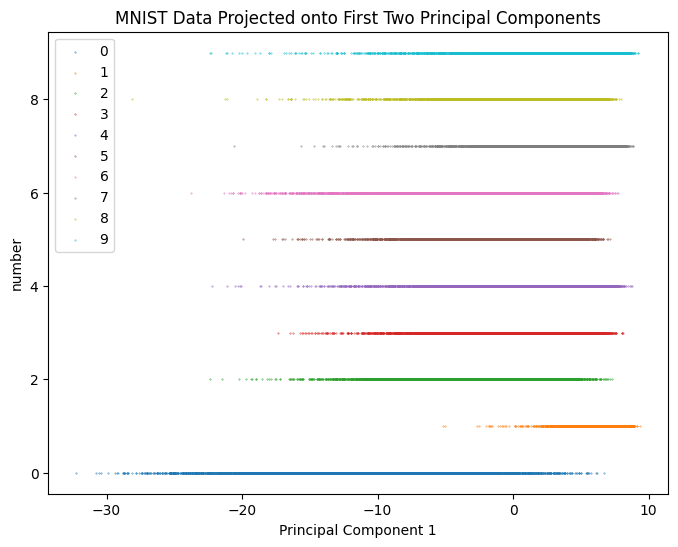

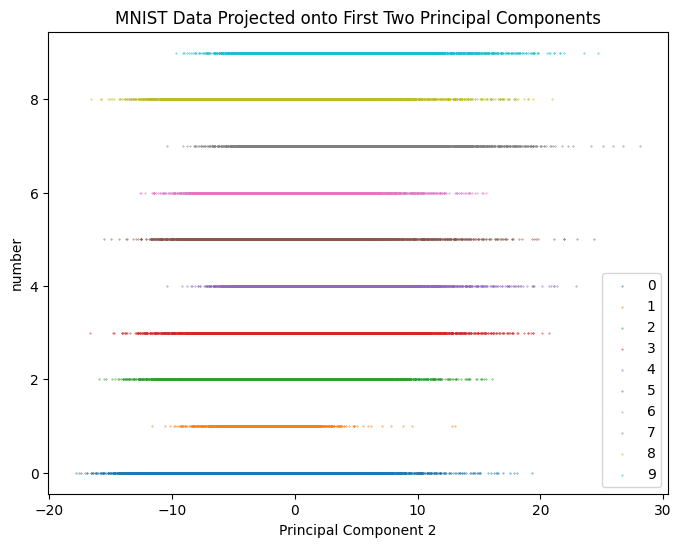

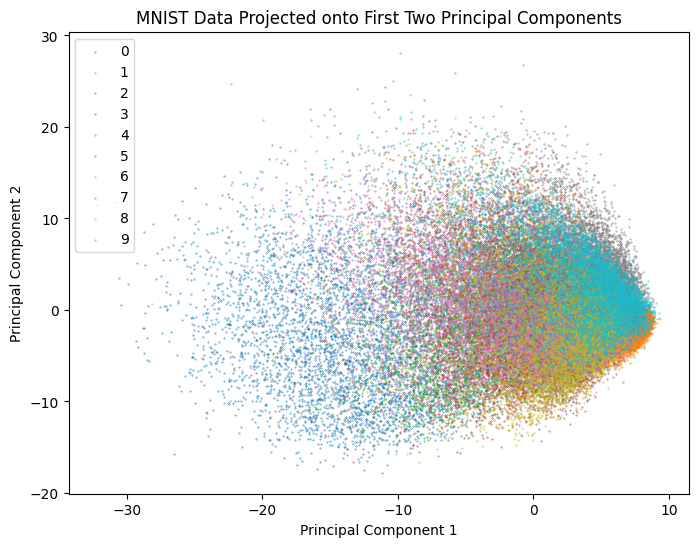

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels == i
    plt.scatter(projected_data[indices, 0], len(projected_data[indices, 1]) * [i], label=str(i), s=0.1)
plt.legend()
plt.title('MNIST Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('number')
plt.show()

plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels == i
    plt.scatter(projected_data[indices, 1], len(projected_data[indices, 1]) * [i], label=str(i), s=0.1)
plt.legend()
plt.title('MNIST Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 2')
plt.ylabel('number')
plt.show()

plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels == i
    plt.scatter(projected_data[indices, 0], projected_data[indices, 1], label=str(i), s=0.1)
plt.legend()
plt.title('MNIST Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

从前两个图看，由于分布并没有分开，很难解释两个维度所代表的特征。
而两个维度所得到的分布图（图三），可以看到除了1，其它点基本都是混在一起的，所以信息应该已经不够了。
下面做一点简单的测试

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# projected_data 是PCA降维后的数据，labels 是标签

# 转换数据为PyTorch张量
X = torch.tensor(projected_data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.int64)

# 创建数据集和数据加载器
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# 定义网络结构
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 50)  # 输入层到隐藏层
        self.fc2 = nn.Linear(50, 10)  # 隐藏层到输出层

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 实例化模型、定义损失函数和优化器
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 1.8651
Epoch [2/10], Loss: 1.7243
Epoch [3/10], Loss: 2.0393
Epoch [4/10], Loss: 1.8200
Epoch [5/10], Loss: 1.3686
Epoch [6/10], Loss: 1.6011
Epoch [7/10], Loss: 1.4939
Epoch [8/10], Loss: 1.5715
Epoch [9/10], Loss: 1.7322
Epoch [10/10], Loss: 1.5388


训练完成以后测试一下，先看看测试集的分布情况

In [68]:
# 加载数据集
test_dataset = datasets.MNIST(root, train=False, download=True)

# 转换图像为NumPy数组
images_test = test_dataset.data.numpy()  # 图像

# 转换标签为NumPy数组
labels_test = test_dataset.targets.numpy()  # 标签

projected_data_test = project(images_test)
print(projected_data_test)

[[  5.45830999   6.41400715]
 [ -2.80442584  -8.02883888]
 [  7.41124105  -3.86404463]
 ...
 [  5.00435096   1.15364821]
 [  1.42085423  -4.42307969]
 [-13.14268136  -4.26280095]]


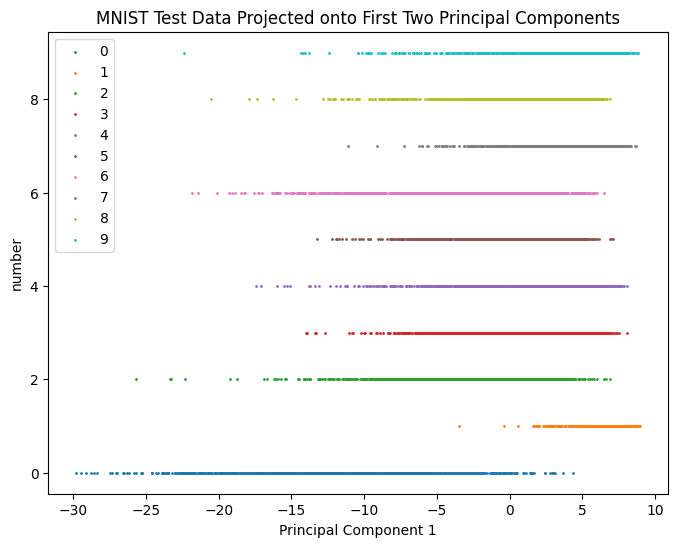

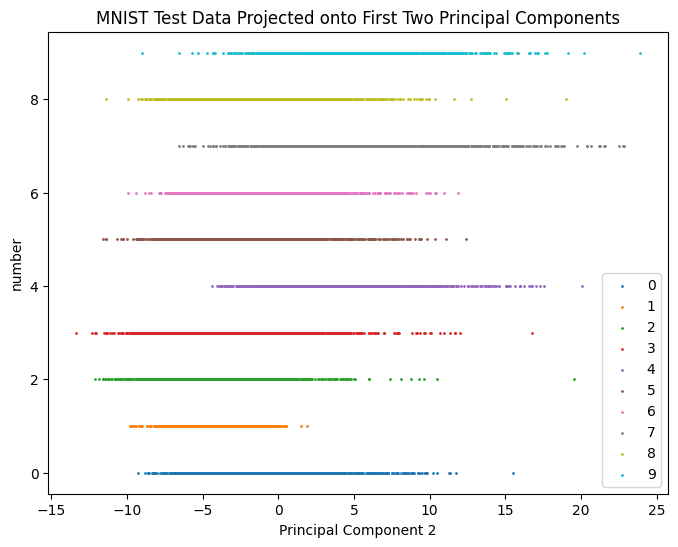

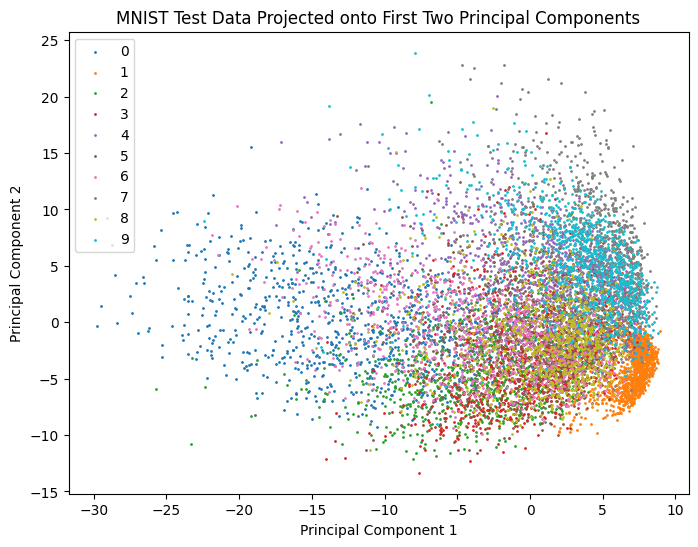

In [69]:
plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels_test == i
    plt.scatter(projected_data_test[indices, 0], len(projected_data_test[indices, 1]) * [i], label=str(i), s=1)
plt.legend()
plt.title('MNIST Test Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('number')
plt.show()

plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels_test == i
    plt.scatter(projected_data_test[indices, 1], len(projected_data_test[indices, 1]) * [i], label=str(i), s=1)
plt.legend()
plt.title('MNIST Test Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 2')
plt.ylabel('number')
plt.show()

plt.figure(figsize=(8, 6))
for i in range(10):  # 对于每个类别（数字0-9）
    indices = labels_test == i
    plt.scatter(projected_data_test[indices, 0], projected_data_test[indices, 1], label=str(i), s=1)
plt.legend()
plt.title('MNIST Test Data Projected onto First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [70]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# 将数据转换为PyTorch张量
X_test = torch.tensor(projected_data_test, dtype=torch.float32)
y_test = torch.tensor(labels_test, dtype=torch.int64)

# 创建测试数据的DataLoader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 将模型设置为评估模式
model.eval()

# 用于存储预测和真实标签
all_preds = []
all_labels = []

# 在不计算梯度的情况下进行预测
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# 计算总体准确率
accuracy = accuracy_score(all_labels, all_preds)
print(f'Total accuracy: {accuracy:.4f}')

# 计算每个类别的准确率
print(classification_report(all_labels, all_preds))


Total accuracy: 0.3462
              precision    recall  f1-score   support

           0       0.48      0.72      0.58       980
           1       0.83      0.89      0.86      1135
           2       0.20      0.28      0.23      1032
           3       0.08      0.04      0.05      1010
           4       0.21      0.13      0.16       982
           5       0.18      0.24      0.20       892
           6       0.20      0.27      0.23       958
           7       0.40      0.70      0.51      1028
           8       0.09      0.01      0.01       974
           9       0.20      0.09      0.13      1009

    accuracy                           0.35     10000
   macro avg       0.29      0.34      0.30     10000
weighted avg       0.30      0.35      0.31     10000



果然，除了1的准确率还尚可接受，其他的数字准确率都很低了